Мета:

Розробити та навчити нейронну мережу для класифікації або регресії на новому наборі даних, використовуючи методи регуляризації для покращення продуктивності моделі та запобігання перенавчанню.
1. Завантаження та попередня обробка даних:
  * Завантажте набір даних та перевірте його на наявність пропущених значень, аномалій та некоректних типів даних.
  * Виконайте нормалізацію чи стандартизацію числових ознак.
  * Розділіть дані на навчальну та тестову вибірки. Якщо набір даних великий, можна також створити валідаційну вибірку для налаштування гіперпараметрів.

In [ ]:
import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn.functional as F



In [3]:
# Завантажте набір даних  
 #https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset/data
# path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")
# print("Path to dataset files:", path)

path  = f'data/'

#перевірте його на наявність пропущених значень, аномалій та некоректних типів даних.
jpg_count = 0
non_jpg_files = []

for root, _, files in os.walk(path):
    for file in files:
        if file.lower().endswith('.jpg'):
            jpg_count += 1
        else:
            non_jpg_files.append(os.path.join(root, file))              
            file_path = os.path.join(root, file)
            os.remove(file_path)
            print(f"Removed: {file_path}")

print(f"Total JPG files: {jpg_count}")
if non_jpg_files:
    print("\nFiles with non-jpg extensions:")
    for file in non_jpg_files:
        print(file)
else:
    print("\nAll files are JPG format!")


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Total JPG files: 1779

All files are JPG format!
Using device: mps


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(
    root='data/',  # Make sure this path points to your image directory
    transform=transform
)

# Define the split ratios
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Total dataset size: 1779
Training set size: 1067
Validation set size: 355
Test set size: 357


2. Створення архітектури нейронної мережі:
  * Визначте архітектуру нейронної мережі з декількох прихованих шарів, використовуючи функцію активації ReLU або іншу, залежно від задачі.
  * Вихідний шар налаштуйте відповідно до типу задачі: для класифікації – з softmax або sigmoid, для регресії – один нейрон із лінійною активацією.

In [6]:
#Визначте архітектуру нейронної мережі з декількох прихованих шарів, використовуючи функцію активації ReLU або іншу, залежно від задачі.
class SimpleImageNet(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleImageNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    writer = SummaryWriter('runs/airplane_training')
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        # Train phase
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            
            running_loss += loss.item()
            running_acc += accuracy
            
            # Log to TensorBoard
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + i)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                accuracy = (predicted == labels).sum().item() / labels.size(0)
                
                val_loss += loss.item()
                val_acc += accuracy
        
        # Calculate epoch metrics
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = running_acc / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_acc / len(val_loader)
        
        # Log epoch metrics to TensorBoard
        writer.add_scalar('Epoch Training Loss', epoch_train_loss, epoch)
        writer.add_scalar('Epoch Training Accuracy', epoch_train_acc, epoch)
        writer.add_scalar('Epoch Validation Loss', epoch_val_loss, epoch)
        writer.add_scalar('Epoch Validation Accuracy', epoch_val_acc, epoch)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print('-' * 50)
    
    writer.close()
    return model


In [13]:
def test_mode(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy =  correct / len(test_loader.dataset)

    return  test_loss, test_accuracy

In [9]:
# Setup
model = SimpleImageNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
trained_model1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=device
)

Epoch [1/10]
Train Loss: 1.1524, Train Acc: 0.3950
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [2/10]
Train Loss: 1.1500, Train Acc: 0.4014
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [3/10]
Train Loss: 1.1500, Train Acc: 0.4014
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [4/10]
Train Loss: 1.1430, Train Acc: 0.4084
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [5/10]
Train Loss: 1.1483, Train Acc: 0.4032
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [6/10]
Train Loss: 1.1465, Train Acc: 0.4049
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [7/10]
Train Loss: 1.1518, Train Acc: 0.3996
Val Loss: 1.1877, Val Acc: 0.3637
--------------------------------------------------
Epoch [8/10]
Train Loss: 1.1500, Train Acc: 0.40

In [16]:
test_loss, test_accuracy = test_mode(trained_model1, test_loader,device=device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

Test Loss: -0.3613, Test Acc: 0.3613


3. Додавання методів регуляризації:
  * Застосуйте регуляризацію L2 (вагову регуляризацію), додаючи штрафні коефіцієнти до ваг моделі для запобігання перенавчанню.
  * Використайте Dropout між прихованими шарами, щоб вимикати випадкові нейрони під час навчання.
  * Можна також застосувати Batch Normalization для покращення збіжності навчання та стабільності роботи моделі.

In [17]:
class ImprovedImageNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ImprovedImageNet, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [19]:
# Setup
model = ImprovedImageNet(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
trained_model2 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=device
)


Epoch [1/10]
Train Loss: 1.0868, Train Acc: 0.4235
Val Loss: 1.0816, Val Acc: 0.4288
--------------------------------------------------
Epoch [2/10]
Train Loss: 1.0479, Train Acc: 0.4621
Val Loss: 1.0572, Val Acc: 0.4653
--------------------------------------------------
Epoch [3/10]
Train Loss: 0.9944, Train Acc: 0.5354
Val Loss: 0.9620, Val Acc: 0.5816
--------------------------------------------------
Epoch [4/10]
Train Loss: 0.9307, Train Acc: 0.6236
Val Loss: 0.9415, Val Acc: 0.6128
--------------------------------------------------
Epoch [5/10]
Train Loss: 0.8567, Train Acc: 0.7031
Val Loss: 0.9215, Val Acc: 0.6285
--------------------------------------------------
Epoch [6/10]
Train Loss: 0.8146, Train Acc: 0.7357
Val Loss: 0.8996, Val Acc: 0.6589
--------------------------------------------------
Epoch [7/10]
Train Loss: 0.7939, Train Acc: 0.7771
Val Loss: 0.8925, Val Acc: 0.6597
--------------------------------------------------
Epoch [8/10]
Train Loss: 0.7463, Train Acc: 0.82

In [20]:
test_loss, test_accuracy = test_mode(trained_model2, test_loader,device=device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

Test Loss: -0.6852, Test Acc: 0.7115


Available class indices: 3
Class names: ['A10', 'A400M', 'B1']


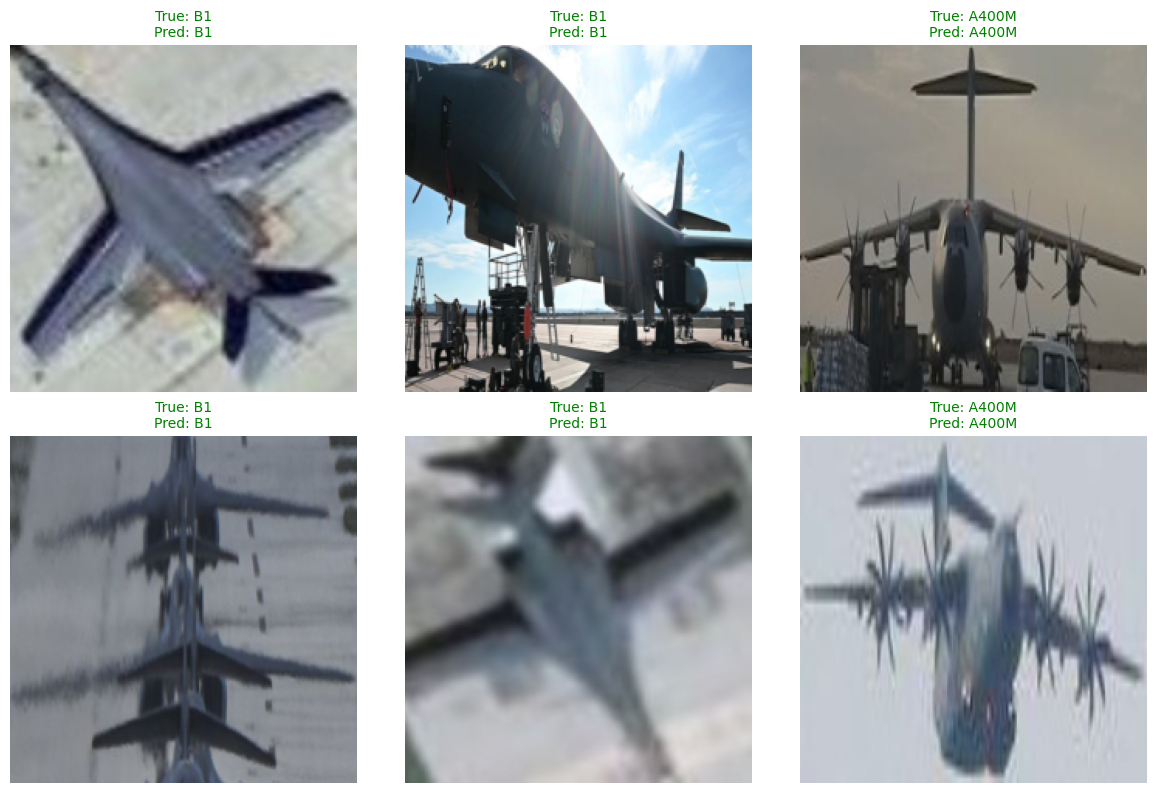

In [21]:
class_names=dataset.classes
model = trained_model2

denorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Print available class indices
print("Available class indices:", len(class_names))
print("Class names:", class_names)

# Get a batch and show predictions with proper indexing
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

# Plot images with valid indices
fig = plt.figure(figsize=(12, 8))
batch_size = min(len(images), 6)
indices = random.sample(range(len(images)), batch_size)

for i in range(batch_size):
    ax = plt.subplot(2, 3, i + 1)
    idx = indices[i]
    
    
    img = images[idx].cpu()
    img = denorm(img)  # denormalize
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # clip values to valid range
    plt.imshow(img)
    
    plt.imshow(img)
    plt.axis('off')
    
    # Get label index and ensure it's within range
    label_idx = labels[idx].cpu().item()
    pred_idx = predicted[idx].cpu().item()
    
    true_label = class_names[label_idx % len(class_names)]
    pred_label = class_names[pred_idx % len(class_names)]
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', 
              color=color,
              fontsize=10)

plt.tight_layout()
plt.show()



Test set: Average loss: 0.8603, Accuracy: 254/357 (71.15%)



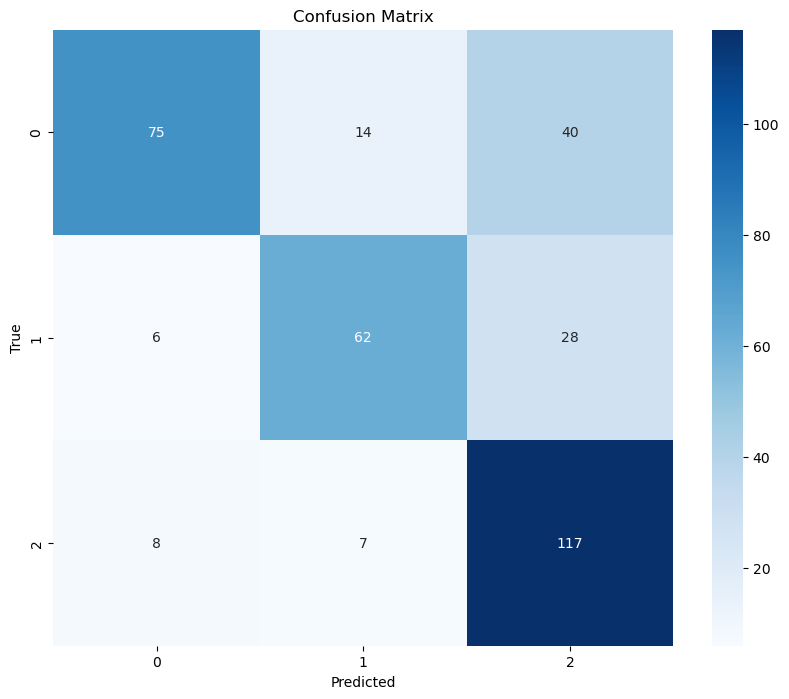

In [22]:
test_loss = 0
correct = 0
all_predictions = []
all_labels = []
wrong_predictions = []

criterion = nn.CrossEntropyLoss()

model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    outputs = model(images)
    test_loss += criterion(outputs, labels).item()
    
    preds = outputs.argmax(dim=1).to(device)
    correct += (preds == labels).sum().item()
    
    all_predictions.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    
    wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]
    for idx in wrong_idx:
        wrong_predictions.append({
            'image': images[idx].cpu(),
            'pred': preds[idx].cpu().item(),
            'true': labels[idx].item()
        })


test_loss /= len(test_loader)
accuracy = 100. * correct / len(test_loader.dataset)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"\nTest set: Average loss: {test_loss:.4f}, "
      f"Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()